## Research Goals

Research suggests that drinking an occasional glass of red wine is good for you. It provides antioxidants, may promote longevity, and can help protect against heart disease and harmful inflammation, among other benefits. However what qualifies a red wine quality to be better than another? Are we able to determine a red wine's quality.

To understand this, we will be looking into red wine based on its physiochemical properties. The research goal of this assignment is to understand the chemical properties that influence the quality of red wines. 

The red wine dataset can be retrieved from https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

and directly from https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/

## Analysis and Findings
To answer these questions we must first aim to understand:
- What makes out red wine? What is the composition of red wine?
- Are all compositions related to one another; are they all related to make out the quality of the wine?
- Are we able to determine a red wine's quality?

Therefore in this assignment, we would be
- Identifying what composition makes out a red wine 
- Exploring how these compositions are related to each other
- Evaluating the best possible method to determine a red wine's quality

## Data Preparation

To query and process our data using Spark SQL, it should be imported into a structure called DataFrame. The data will be imported to a DataFrame named "RedWData".

In [1]:
RedWData = spark.read.csv("/home/training/data/Assignment/winequality-red.csv", inferSchema = True, header=True)

When reading the data, it is indicated that the data contains a header line and we would like Spark SQL to infer the schema. We will also use the count method to count the number of rows in the DataFrame.

In [2]:
RedWData.printSchema()
RedWData.count()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)
 |-- color: string (nullable = true)



1616

From the printSchema function we are able to determine that there are 13 columns:
- 11 having the data type double
- 1 having the data type integer 
- 1 having the data type string

The columns are describe as such (retrieved from the source description in kaggle):
- fixed acidity:
    - most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
- volatile acidity: 
    - the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
- citric acid: 
    - found in small quantities, citric acid can add 'freshness' and flavor to wines
- residual sugar: 
    - the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet
- chlorides: 
    - the amount of salt in the wine
- free sulfur dioxide: 
    - the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
- total sulfur dioxide: 
    - amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
- density: 
    - the density of water is close to that of water depending on the percent alcohol and sugar content
- pH: 
    - describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
- sulphates:
    - a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
- alcohol: 
    - the percent alcohol content of the wine
- quality:
    - output variable (based on sensory data, score between 0 and 10)
- color:
    - output variable (red color)
    
We are also able to retrieve that the dataset has a total of 1616 rows of data. 

We will show a sample of the information from the datasets by showing the first 5 rows.

In [3]:
RedWData.show(5)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|color|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+-----+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|  red|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|  red|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|  red|
|         11.2|            0.28|       0.56|           1.9|    0

Now, let us look at how to handle data with missing values in one or more fields among its records. The missing values could be due to system failure, people error or change in data schema. We will check what percentage of missing values are there in each column.

In [4]:
import pyspark.sql.functions as fn

RedWData.agg( * [(1 - fn.count(c) / fn.count("*")).alias(c + '_missing') for c in RedWData.columns] ).show()

+---------------------+------------------------+--------------------+----------------------+--------------------+---------------------------+----------------------------+---------------+--------------------+--------------------+--------------------+---------------+--------------------+
|fixed acidity_missing|volatile acidity_missing| citric acid_missing|residual sugar_missing|   chlorides_missing|free sulfur dioxide_missing|total sulfur dioxide_missing|density_missing|          pH_missing|   sulphates_missing|     alcohol_missing|quality_missing|       color_missing|
+---------------------+------------------------+--------------------+----------------------+--------------------+---------------------------+----------------------------+---------------+--------------------+--------------------+--------------------+---------------+--------------------+
|                  0.0|     0.00433168316831678|0.001856435643564...|                   0.0|0.002475247524752...|       6.188118811880639E-

Seeing the missing percentages from the results, we would not be dropping any coloumns in entirety. 

We notice that that are some rows missing the data cell for color, which is a string data type. We can simply fill the column as we know that the string should only be "red" for red wine.

We also notice that the dataset has missing cells for the wine's physiochemical properties, a way would be to calculate the mean of all the entries to fill the missing cells, however this may alter the comparison as well as the prediction in the quality of wine. Instead, we will deal with the data rows with missing values by removing them instead. 

In [5]:
RedWData2 = RedWData.fillna("red", "color")

RedWine = RedWData2.dropna(subset=["volatile acidity", "citric acid", "chlorides", 
                                      "free sulfur dioxide", "total sulfur dioxide", 
                                   "pH", "sulphates", "alcohol"])

RedWine.agg( * [(1 - fn.count(c) / fn.count("*")).alias(c + '_missing') for c in RedWine.columns] ).show()

+---------------------+------------------------+-------------------+----------------------+-----------------+---------------------------+----------------------------+---------------+----------+-----------------+---------------+---------------+-------------+
|fixed acidity_missing|volatile acidity_missing|citric acid_missing|residual sugar_missing|chlorides_missing|free sulfur dioxide_missing|total sulfur dioxide_missing|density_missing|pH_missing|sulphates_missing|alcohol_missing|quality_missing|color_missing|
+---------------------+------------------------+-------------------+----------------------+-----------------+---------------------------+----------------------------+---------------+----------+-----------------+---------------+---------------+-------------+
|                  0.0|                     0.0|                0.0|                   0.0|              0.0|                        0.0|                         0.0|            0.0|       0.0|              0.0|            0.0

In [6]:
RedWine.count()

1602

After recounting, we can see that we still have an ample amount of rows for our prediction. We will also use the modifed dataframe, currently it is now named "RedWine".

## Data Exploration

In [7]:
# Generate matplotlib library 
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

By plotting a histogram, we are able to show how each column is in its skewness. We have also calculated the skewness for each physiochemical input. We will add our input column that we would like to see in a list, for these oberservations we will not be listing the column 'color'.

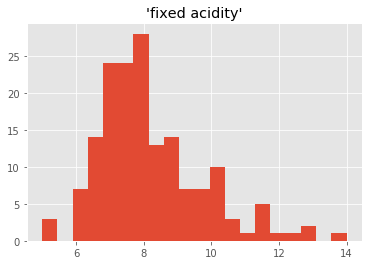

+-----------------------+
|skewness(fixed acidity)|
+-----------------------+
|     1.0388948273864056|
+-----------------------+



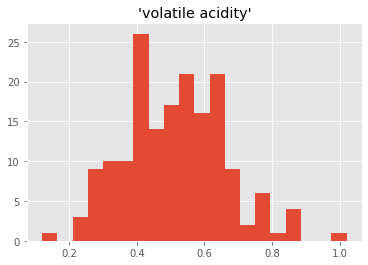

+--------------------------+
|skewness(volatile acidity)|
+--------------------------+
|        0.3156118368789914|
+--------------------------+



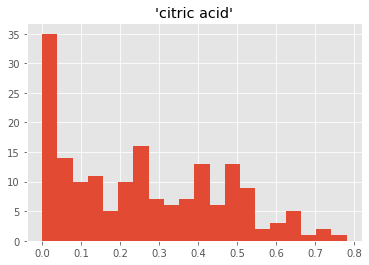

+---------------------+
|skewness(citric acid)|
+---------------------+
|   0.4199206312213668|
+---------------------+



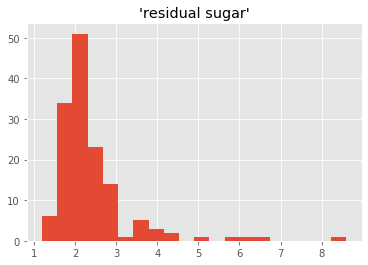

+------------------------+
|skewness(residual sugar)|
+------------------------+
|       3.175367218484933|
+------------------------+



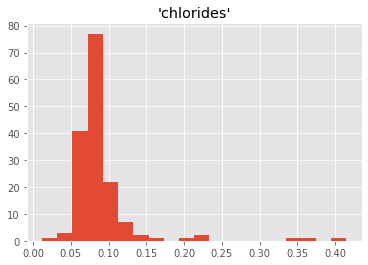

+-------------------+
|skewness(chlorides)|
+-------------------+
|  4.530137464890369|
+-------------------+



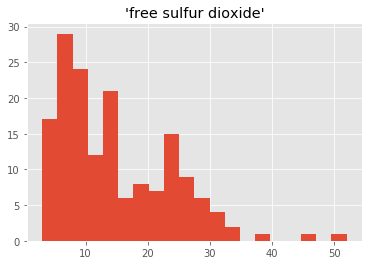

+-----------------------------+
|skewness(free sulfur dioxide)|
+-----------------------------+
|           1.0354003546857506|
+-----------------------------+



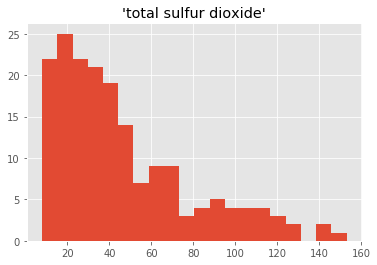

+------------------------------+
|skewness(total sulfur dioxide)|
+------------------------------+
|            1.1941428780582402|
+------------------------------+



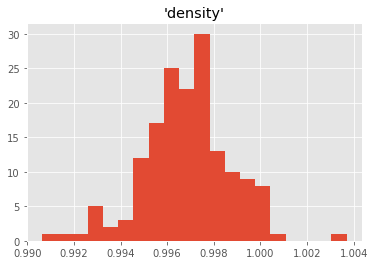

+--------------------+
|   skewness(density)|
+--------------------+
|-0.15970622334423082|
+--------------------+



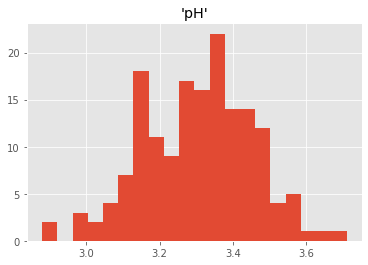

+--------------------+
|        skewness(pH)|
+--------------------+
|-0.14935810917616754|
+--------------------+



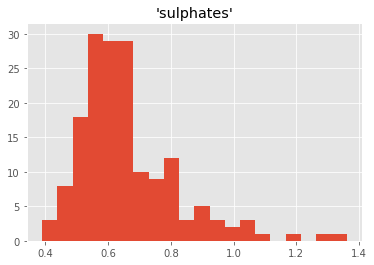

+-------------------+
|skewness(sulphates)|
+-------------------+
| 1.5379207153991366|
+-------------------+



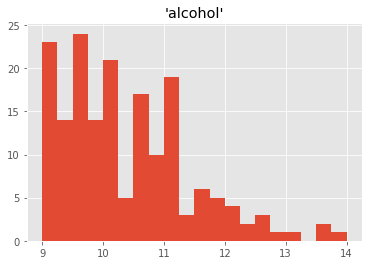

+------------------+
| skewness(alcohol)|
+------------------+
|1.0017812635449854|
+------------------+



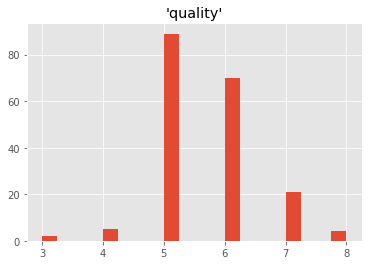

+-------------------+
|  skewness(quality)|
+-------------------+
|0.37256769602016654|
+-------------------+



In [8]:
column = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
             'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']

for h in range(len(column)):
    RWDF = RedWine.sample(fraction = 0.1)
    bal_list = [h[0] for h in RWDF.select(column[h]).collect()]
    plt.title(f"'{column[h]}'")
    plt.hist(bal_list, bins = 20)
    plt.show()
    RWDF.agg({f'{column[h]}': 'skewness'}).show()

We can also describe our input column physiochemical and outputs.

In [9]:
desc = RWDF.describe(column)
desc.show()

+-------+------------------+------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+
|summary|     fixed acidity|  volatile acidity|        citric acid|    residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|          sulphates|           alcohol|           quality|
+-------+------------------+------------------+-------------------+------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+
|  count|               191|               191|                191|               191|                191|                191|                 191|                 191|                191|                191|               191|               191|
|   mean| 8.

From our skewness and description, we can notice the following:
- All the input physiochemicals are positively skewed. 
- The coefficient of variation (ratio of mean to standard deviation) is not high suggesting that some of the observations are not far spread out.

For more information on the physiochemical inputs in relation to the quality of wine, we can plot box plot which allows us to see how are they related. A box plot is also able to graph out the min, mean, max, lower quartile and upper quartile as well as looking out for outliers in our oberservations.

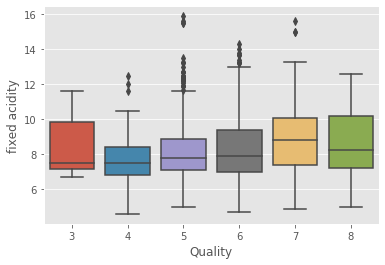

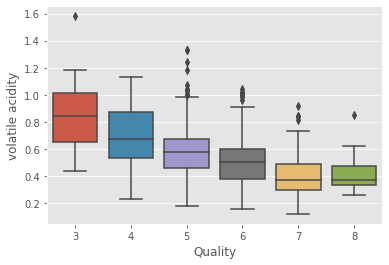

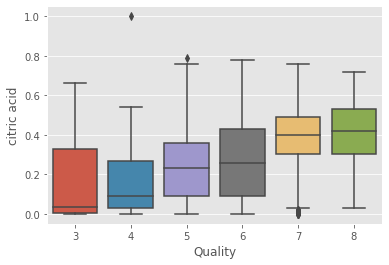

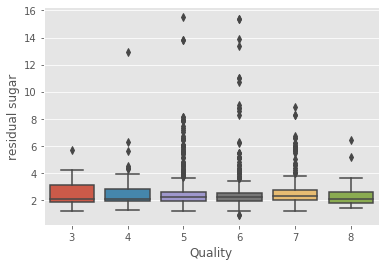

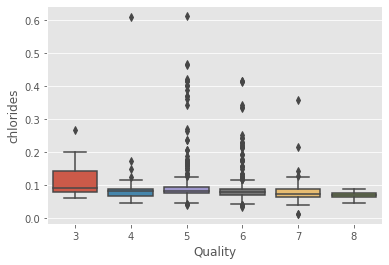

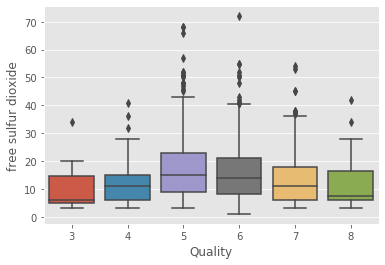

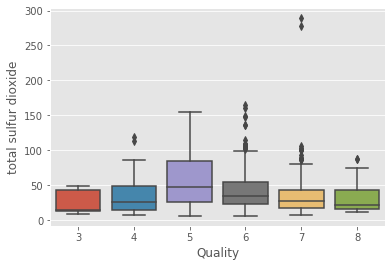

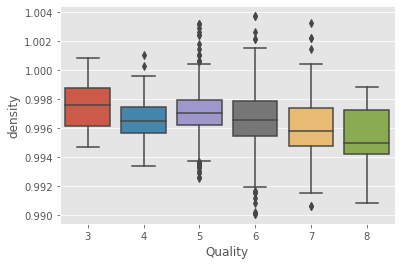

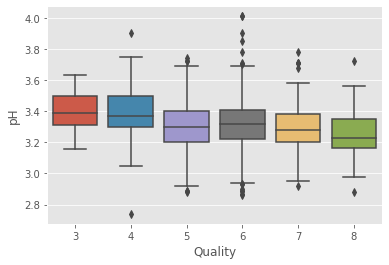

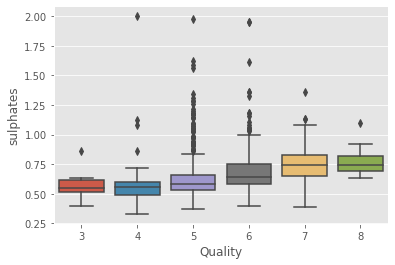

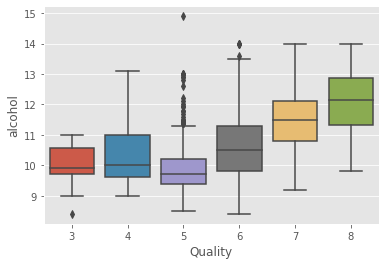

In [10]:
column2 = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
             'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']

for i in range(len(column2)):
    ax = sns.boxplot(x="quality", y=column2[i], data=RedWine.toPandas())
    ax.set_xlabel("Quality")
    ax.set_ylabel(f"{column2[i]}")
    plt.show()

From our box plot observations, we are able to detect that there are outliers in our dataset, however I have chosen not to take them out as, different levels in physiochemical can result in a better or lesser quality of wine; taking these observation may result in a list of wine with the same quality and physiochemical properties.

We can see on the box plot that they maybe a pattern in our physichemicals in realtion to quality. Plotting a bar graph could help us see the pattern more clarity.

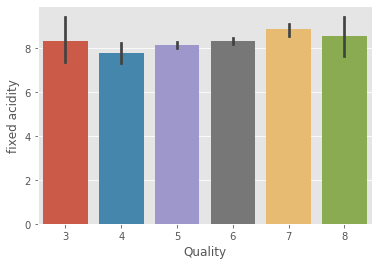

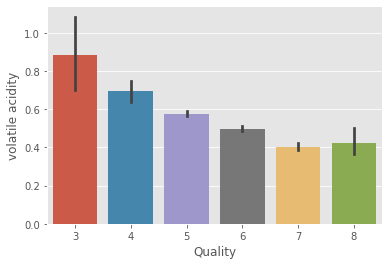

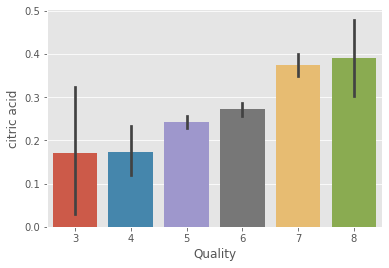

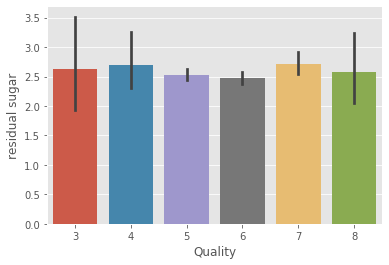

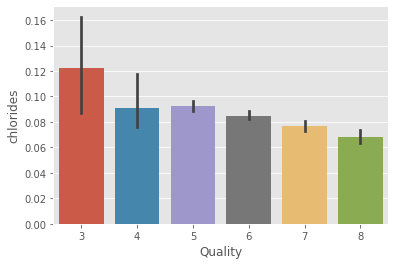

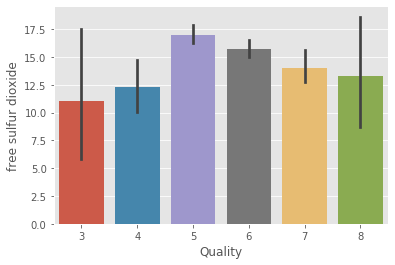

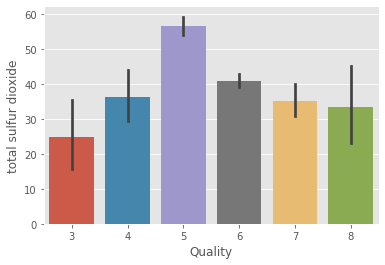

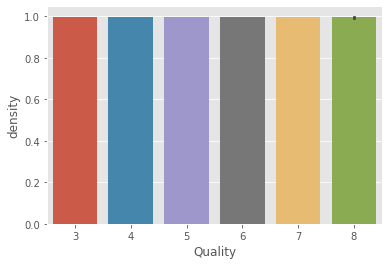

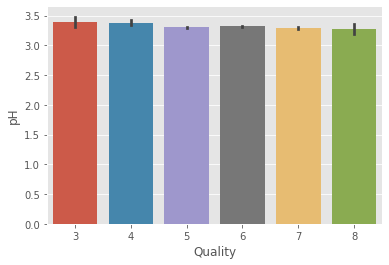

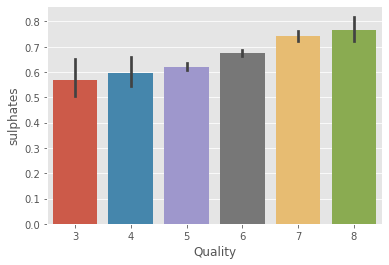

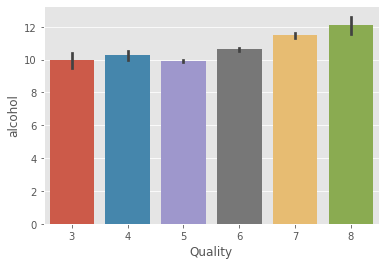

In [11]:
for i in range(len(column2)):
    ax = sns.barplot(x="quality", y=column2[i], data=RedWine.toPandas())
    ax.set_xlabel("Quality")
    ax.set_ylabel(f"{column2[i]}")
    plt.show()

From the bar graph, we can make out the following observations:
- Increase in quality by decreasing volatile acidity levels
- Increase in quality by increasing citric acid levels
- Increase in quality by decreasing chloride levels
- Increase in quality by decreasing pH levels (slight)
- Increase in quality by increasing sulphates levels
- Increase in quality by increasing alcohol levels

We can also see that:
- density levels stay the same in all quality levels
- 'free sulfur dioxide' and 'total sulfur dioxide' does not seem to affect quality levels
- 'fixed acidity' and 'residual sugar' levels does not seem to affect quality levels

So far we have only seen how each physiochemical is related to quality, however what about to each other. Calculating a correlation coefficients matrix can help us understand more about our data.

In [12]:
n_column = len(column)
corr = []

for i in range(0, n_column):
    temp = [None] * i
    for j in range(i, n_column):
        temp.append(RedWine.corr(column[i], column[j]))
    corr.append(temp)

# print the correlation matrix in a nicely formatted table
from tabulate import tabulate
print(tabulate(corr, headers=column, showindex=column, tablefmt="fancy_grid", numalign="center"))

╒══════════════════════╤═════════════════╤════════════════════╤═══════════════╤══════════════════╤═════════════╤═══════════════════════╤════════════════════════╤════════════╤════════════╤═════════════╤════════════╤════════════╕
│                      │  fixed acidity  │  volatile acidity  │  citric acid  │  residual sugar  │  chlorides  │  free sulfur dioxide  │  total sulfur dioxide  │  density   │     pH     │  sulphates  │  alcohol   │  quality   │
╞══════════════════════╪═════════════════╪════════════════════╪═══════════════╪══════════════════╪═════════════╪═══════════════════════╪════════════════════════╪════════════╪════════════╪═════════════╪════════════╪════════════╡
│ fixed acidity        │        1        │     -0.256641      │   0.671902    │     0.115256     │  0.0934213  │       -0.153514       │       -0.112821        │  0.667786  │  -0.68308  │  0.183454   │ -0.0599359 │  0.123437  │
├──────────────────────┼─────────────────┼────────────────────┼───────────────┼─────────

From the correlation table, we can make the following observations:
- volatile acidity related at -0.385 correlation coefficient to quality
- citric acid related at 0.224 correlation coefficient to quality
- chloride related at -0.128 correlation coefficient to quality
- pH related -0.057 correlation coefficient to quality
- sulphates related at 0.250 correlation coefficient to quality
- alcohol related at 0.474 correlation coefficient to quality

We can confirm that the following observations mentioned are of the same observations that we have seen in our bar graph observation. 

We can also make the following observations:
- free sulfur dioxide and total sulfur dioxide seems to be strongly related to each other at 0.667 correlation coefficient
- citric acid seems to be related to fixed acidity and volatile acidity and citric acid at 0.67, -0.5528 and -0.541 correlation coefficient respectively
- fixed acidity seems to be related to density and pH at 0.667 and -0.683 correlation coefficient respectively

## Data Modeling (Using Classification) 
We will proceed to model our data for predictive analysis, for this assignment I have decided to simplify the models in predicting by classifying the quality into 3 groups. The classified groups are:
- "Good" for quality levels 0 to 3 , it will be assigned to the number 0
- "Great" for quality levels 4 to 6 , it will be assigned to the number 1
- "Excellent" for quality levels 7 to 10 , it will be assigned to the number 2

In [13]:
RedWine2 = RedWine.replace([0,1,2,3], 0, "quality")
RedWine3 = RedWine2.replace([4,5,6], 1, "quality")
RedWineFinal = RedWine3.replace([7,8,9,10], 2, "quality")

We would be using the classification analysis models. A classification model takes input values given for training and tries to use them to predict categories for the new data. In this case, to take in levels of physiochemical levels and determine which of the 3 classified quality groups it belongs to.

In order to do so, we must first determine the best model to use. The models we will be using are:
- Decision Tree Classifier
- Logistic Regression
- Random Forest Classifier
- Naive Bayes Classifier

We will first import all our needed functions.

In [14]:
import pyspark.ml.feature as ft
from pyspark.ml import Pipeline
import pyspark.ml.evaluation as ev
import pyspark.ml.classification as cl

For the analysis, I have decided to use 70% of the data towards training and 30% towards testing our models.

In [15]:
train, test = RedWineFinal.randomSplit([0.7, 0.3], seed=1)

We will be using the VectorAssembler to assemble the values from all the input columns into the output column. I have decided to choose all the columns except for 'free sulfur dioxide' and 'total sulfur dioxide' where they show no strong correlation to our 'quality' output but are strongly related to each other.

In [16]:
featuresCreator = ft.VectorAssembler(inputCols=['fixed acidity','volatile acidity','citric acid','residual sugar',
                                                'chlorides','density','pH','sulphates','alcohol'], 
                                     outputCol="features")

The following will be done to all models in the same order:
- Estimator of choice will be use to classify the model
- A Pipeline is created to pull the different transformations together
- Use the pipeline to train our model using our train data
- Use the model to make a prediction using our test data

I will also mention any additional parameters made in the model when choosing the estimator.

### Decision Tree Classifier

In [17]:
# Train a DecisionTree model.
dt = cl.DecisionTreeClassifier(labelCol="quality")

# Chain tree in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, dt])

# Train model. 
model = pipeline.fit(train)

# Make predictions.
predictionsdt = model.transform(test)

### Logistic Regression
For the model for Logistic Regression, I have decided to set the number of iterations the algorithm will run at 50. I have decided to also set the regParam and elasticNetParam to 0.01 to handle overfitting of the data for our model.

In [18]:
# Train a LogisticRegression model.
lr = cl.LogisticRegression(regParam=0.01, maxIter=50, elasticNetParam=0.01, labelCol="quality")

# Chain tree in a Pipeline
pipeline = Pipeline(stages = [featuresCreator, lr])

# Train model and transform to test model
model = pipeline.fit(train)

# Make predictions.
predictionslr = model.transform(test)

### Random Forest Classifier
For the model for Random Forest, I have decided to set the number of trees to 50 to potentially increase the performance of the model.

In [19]:
# Train a RandomForest model.
rf = cl.RandomForestClassifier(labelCol="quality", numTrees=50)

# Chain forest in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, rf])

# Train model.  
model = pipeline.fit(train)

# Make predictions.
predictionsrf = model.transform(test)

### Naive Bayes Classifier

In [20]:
# Train a Naive Bayes model.
nb = cl.NaiveBayes(labelCol="quality")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[featuresCreator, nb])

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictionsnb = model.transform(test)

## Evaluation (Classification Models)

In [21]:
print('The Accuracy score for Decision Tree Classifier is : \t', ev.MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='quality',
                                                      metricName='accuracy').evaluate(predictionsdt))
print('The Accuracy score for Logistics Regression is : \t', ev.MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='quality',
                                                      metricName='accuracy').evaluate(predictionslr))
print('The Accuracy score for Random Forest Classifier is : \t', ev.MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='quality',
                                                      metricName='accuracy').evaluate(predictionsrf))
print('The Accuracy score for Naive Bayes Classifier is : \t', ev.MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='quality',
                                                      metricName='accuracy').evaluate(predictionsnb))

The Accuracy score for Decision Tree Classifier is : 	 0.8600823045267489
The Accuracy score for Logistics Regression is : 	 0.8806584362139918
The Accuracy score for Random Forest Classifier is : 	 0.8765432098765432
The Accuracy score for Naive Bayes Classifier is : 	 0.8786008230452675


We can evaluate and see which is our best model to predict the quality of our wine.

To do so I have printed the following accruracy scores of the classifier models. Accuracy shows the percentage that the model has predicted correctly.

Based on the performance metrics above, the best model that therefore gives me the best accuracy is the **Logistic Regression model** at a score of 0.880.


## Data Modeling (Using Regression)
We can also approach in predicting the dataset by using regression models. A regression model takes input values given for training and tries to use them to predict trends using the data. 

The models we will be using are:
- Generalized Linear Regression
- Decision Tree Regression
- Random Forest Regression
- Gradient Boost Regression

We will first import all our needed functions and some of the previous imported functions. We will also be using 70% of the data towards training and 30% towards testing our models previously split as well as the featureCreator.

In [22]:
import pyspark.ml.regression as reg

The following will be done to all models in the same order:
- Estimator of choice will be use to regress the model
- A Pipeline is created to pull the different transformations together
- Use the pipeline to train our model using our train data
- Use the model to make a prediction using our test data

### Generalized Linear Regression

In [23]:
# Train a Regression model.
lr = reg.GeneralizedLinearRegression(labelCol="quality")

# Chain tree in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, lr])

# Train model. 
model = pipeline.fit(train)

# Make predictions
predictionslr = model.transform(test)

### Decision Tree Regression

In [24]:
# Train a DT Regression model.
dt = reg.DecisionTreeRegressor(labelCol="quality")

# Chain tree in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, dt])

# Train model. 
model = pipeline.fit(train)

# Make predictions
predictionsdt = model.transform(test)

### Random Forest Regression

In [25]:
# Train a RandomForest model.
rf = reg.RandomForestRegressor(labelCol="quality")

# Chain forest in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, rf])

# Train model.  
model = pipeline.fit(train)

# Make predictions.
predictionsrf = model.transform(test)

### Gradient Boost Regression

In [26]:
# Train a Gradient Boost model.
gbt = reg.GBTRegressor(labelCol="quality")

# Chain forest in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, gbt])

# Train model.  
model = pipeline.fit(train)

# Make predictions.
predictionsgbt = model.transform(test)

## Evaluation (Regression)

In [27]:
evaluator = ev.RegressionEvaluator(predictionCol="prediction", labelCol="quality")
print('The RMSE for Generalized Linear Regression is : \t' , evaluator.evaluate(predictionslr, {evaluator.metricName: 'rmse'}))
print('The R2 score for Generalized Linear Regression is : \t' , evaluator.evaluate(predictionslr, {evaluator.metricName: 'r2'}))

print('\nThe RMSE for Decision Tree Regression is : \t\t' , evaluator.evaluate(predictionsdt, {evaluator.metricName: 'rmse'}))
print('The R2 score for Decision Tree Regression is : \t\t' , evaluator.evaluate(predictionsdt, {evaluator.metricName: 'r2'}))

print('\nThe RMSE for Random Forest Regression is : \t\t' , evaluator.evaluate(predictionsrf, {evaluator.metricName: 'rmse'}))
print('The R2 score for Random Forest Regression is : \t\t' , evaluator.evaluate(predictionsrf, {evaluator.metricName: 'r2'}))

print('\nThe RMSE for Gradient Boost Regression is : \t\t' , evaluator.evaluate(predictionsgbt, {evaluator.metricName: 'rmse'}))
print('The R2 score for Gradient Boost Regression is : \t' , evaluator.evaluate(predictionsgbt, {evaluator.metricName: 'r2'}))

The RMSE for Generalized Linear Regression is : 	 0.3016322455603147
The R2 score for Generalized Linear Regression is : 	 0.15478516409671605

The RMSE for Decision Tree Regression is : 		 0.3492656674777336
The R2 score for Decision Tree Regression is : 		 -0.13324384992075444

The RMSE for Random Forest Regression is : 		 0.29637989357164546
The R2 score for Random Forest Regression is : 		 0.1839644997406933

The RMSE for Gradient Boost Regression is : 		 0.33756363890048374
The R2 score for Gradient Boost Regression is : 	 -0.058578079757956925


We can see from the RMSE that the models have only a 2-4% error however the R2 scores are not ideal, projecting as low as 0.154 to even -0.13. The low R2 score could be a result of underfitting in the model. Underfitting refers to a model that cannot model the training data and test the data.

## Data Modeling (Using Regression 2nd Attempt)
We will run the regression models again but this time, as the models were underfitted, I have decided to train 90% of the data and test 10% of it for the models. Parameters are also added for the models to have the best fit for the models.

In [28]:
trainr, testr = RedWine.randomSplit([0.9, 0.1], seed=50)

### Generalized Linear Regression

In [29]:
# Train a Regression model.
glr = reg.GeneralizedLinearRegression(labelCol="quality")

# Chain tree in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, glr])

# Train model. 
model = pipeline.fit(trainr)

# Make predictions
predictionsglr = model.transform(testr)

### Decision Tree Regression

In [30]:
# Train a DT Regression model.
dtr = reg.DecisionTreeRegressor(labelCol="quality")

# Chain tree in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, dtr])

# Train model. 
model = pipeline.fit(trainr)

# Make predictions
predictionsdtr = model.transform(testr)

### Random Forest Regression
For the model for Random Forest Regression, I have decided to set the number of trees to 50 to potentially increase the performance of the model. I have also set the maxDepth to 4.

In [31]:
# Train a RandomForest model.
rfr = reg.RandomForestRegressor(labelCol="quality", numTrees=50, maxDepth=4)

# Chain forest in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, rfr])

# Train model.  
model = pipeline.fit(trainr)

# Make predictions.
predictionsrfr = model.transform(testr)

### Gradient Boost Regression
For the model for Gradient Boost Regression, I have decided to set the maxDepth to 4 as a maxIter to 5 to potentially increase the performance of the model.

In [32]:
# Train a Gradient Boost model.
gbt = reg.GBTRegressor(labelCol="quality", maxDepth=4, maxIter=5)

# Chain forest in a Pipeline
pipeline = Pipeline(stages =[featuresCreator, gbt])

# Train model.  
model = pipeline.fit(trainr)

# Make predictions.
predictionsgbt2 = model.transform(testr)

## Evaluation (Regression 2nd Attempt)

In [33]:
evaluator = ev.RegressionEvaluator(predictionCol="prediction", labelCol="quality")
print('The RMSE for Generalized Linear Regression is : \t' , evaluator.evaluate(predictionsglr, {evaluator.metricName: 'rmse'}))
print('The R2 score for Generalized Linear Regression is : \t' , evaluator.evaluate(predictionsglr, {evaluator.metricName: 'r2'}))

print('\nThe RMSE for Decision Tree Regression is : \t\t' , evaluator.evaluate(predictionsdtr, {evaluator.metricName: 'rmse'}))
print('The R2 score for Decision Tree Regression is : \t\t' , evaluator.evaluate(predictionsdtr, {evaluator.metricName: 'r2'}))

print('\nThe RMSE for Random Forest Regression is : \t\t' , evaluator.evaluate(predictionsrfr, {evaluator.metricName: 'rmse'}))
print('The R2 score for Random Forest Regression is : \t\t' , evaluator.evaluate(predictionsrfr, {evaluator.metricName: 'r2'}))

print('\nThe RMSE for Gradient Boost Regression is : \t\t' , evaluator.evaluate(predictionsgbt2, {evaluator.metricName: 'rmse'}))
print('The R2 score for Gradient Boost Regression is : \t' , evaluator.evaluate(predictionsgbt2, {evaluator.metricName: 'r2'}))

The RMSE for Generalized Linear Regression is : 	 0.6193072034931931
The R2 score for Generalized Linear Regression is : 	 0.38629123971563784

The RMSE for Decision Tree Regression is : 		 0.6446690948600813
The R2 score for Decision Tree Regression is : 		 0.33499676015570934

The RMSE for Random Forest Regression is : 		 0.5966669087841134
The R2 score for Random Forest Regression is : 		 0.4303423099606827

The RMSE for Gradient Boost Regression is : 		 0.6116859286585783
The R2 score for Gradient Boost Regression is : 	 0.40130305848271863


The results came out better than our lst attempt with the input of more training data and parameters. The RMSE scores for the models show a error percentage of around 5.5-6.5% range. 

The R2 scores are still considered a bit low despite changing the data split and parameters; this could also be caused by the outliers that are still existing in the dataset; as some red wine have high quality but with physichemical properties  that are out of the trend in relation to the quality.

Therefore considering the outliers, the R2 scores are considered an acceptable effect size.

Based on the scores above, the best model that therefore gives me the best R2 score is the **Random Forest Regression model** at a R2 score of 0.430 and a RMSE score at 0.597.